# 캐글 신용카드사기 예측
데이터가 1차적으로 처리되어 있고 
PCA로 차원축소 및 익명화 되어있어 칼럼명을 알 수 없다.

## 필요 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 데이터 준비

In [2]:
card_df = pd.read_csv('data/creditcard.csv')

In [3]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
card_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


## 데이터 전처리

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop(columns=['Time'], inplace=True)
    return df_copy

In [7]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X = df_copy.iloc[:,:-1]
    y = df_copy.iloc[:,-1]
    
    X_train,X_test,y_train,y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.3,
                                                     random_state=0,
                                                     stratify=y)
    return X_train,X_test,y_train,y_test

In [8]:
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)

In [9]:
y_train.value_counts() / y_train.shape[0] * 100

0    99.827451
1     0.172549
Name: Class, dtype: float64

In [10]:
y_test.value_counts() / y_test.shape[0] * 100

0    99.826785
1     0.173215
Name: Class, dtype: float64

## 로지스틱회귀를 통한 분류모델 생성

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr_clf = LogisticRegression()

In [13]:
def get_clf_eval(y_test,pred,pred_proba):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율:{recall:.4f}, f1-스코어:{f1:.4f}, auc스코어:{auc:.4f}')

In [14]:
def get_model_train_eval(model, X_train,X_test,y_train,y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]
    get_clf_eval(y_test,pred,pred_proba)

In [15]:
get_model_train_eval(lr_clf, X_train,X_test,y_train,y_test)

오차행렬
[[85279    16]
 [   58    90]]
정확도: 0.9991, 정밀도: 0.8491, 재현율:0.6081, f1-스코어:0.7087, auc스코어:0.9589


## LGBM를 통한 분류모델 생성

In [16]:
from lightgbm import LGBMClassifier

In [17]:
lgbm_clf = LGBMClassifier(n_estimators=1000,
                         num_leaves=64,
                         n_jobs=-1,
                         boost_from_average=False)

In [18]:
get_model_train_eval(lgbm_clf, X_train,X_test,y_train,y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율:0.7568, f1-스코어:0.8453, auc스코어:0.9790


## Amount의 분포 확인

In [19]:
import seaborn as sns

<AxesSubplot:xlabel='Amount', ylabel='Density'>

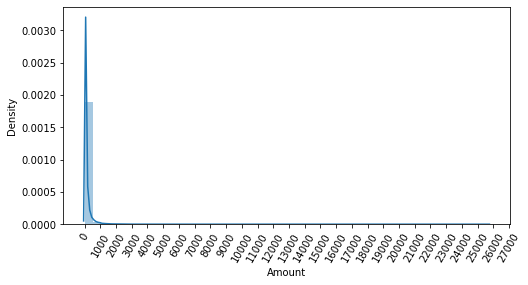

In [20]:
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
card_df = pd.read_csv('data/creditcard.csv')

In [23]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(columns=['Time'], inplace=True)
    return df_copy

In [24]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X = df_copy.iloc[:,:-1]
    y = df_copy.iloc[:,-1]
    
    X_train,X_test,y_train,y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.3,
                                                     random_state=0,
                                                     stratify=y)
    return X_train,X_test,y_train,y_test

In [25]:
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
X_train,X_test,y_train,y_test

(        Amount_Scaled        V1        V2        V3        V4        V5  \
 211605      -0.350471 -8.367621  7.402969 -5.114191 -2.966792 -0.985904   
 231628      -0.131456 -1.290662  0.764452 -0.169233 -1.688528  1.984718   
 110643      -0.307251 -0.606860  0.233923  2.633361 -0.155762 -0.328850   
 11478       -0.313249  1.374168 -0.330389  0.812971 -0.183112 -1.074771   
 243724       8.802588 -2.146505 -7.603113 -4.928224  1.449173 -2.083871   
 ...               ...       ...       ...       ...       ...       ...   
 88290       -0.293938 -1.993953  1.734986 -1.108037 -2.671817  1.605319   
 22346       -0.342914 -0.440396  1.062920  1.582218 -0.029761  0.040967   
 269968       2.637499  0.827820 -2.649344 -3.161235  0.209209 -0.561331   
 175960       6.729380 -1.523903 -6.287060 -2.638246  1.330015 -1.672002   
 47973        0.413604 -1.608560  0.132746  2.075995 -1.937332 -1.822305   
 
               V6        V7        V8        V9  ...       V20       V21  \
 211605 -1

In [26]:
get_model_train_eval(lr_clf, X_train,X_test,y_train,y_test)

오차행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율:0.6014, f1-스코어:0.7149, auc스코어:0.9648


In [27]:
lgbm_clf = LGBMClassifier(n_estimators=1000,
                         num_leaves=64,
                         n_jobs=-1,
                         boost_from_average=False)

In [28]:
get_model_train_eval(lgbm_clf, X_train,X_test,y_train,y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율:0.7568, f1-스코어:0.8453, auc스코어:0.9812


## Logistic Regression
### 변환 전
정확도: 0.9991, 정밀도: 0.8491, 재현율:0.6081, f1-스코어:0.7087, auc스코어:0.9589
### 변환 후
정확도: 0.9992, 정밀도: 0.8812, 재현율:0.6014, f1-스코어:0.7149, auc스코어:0.9648
## LightGBM
### 변환 전
정확도: 0.9995, 정밀도: 0.9573, 재현율:0.7568, f1-스코어:0.8453, auc스코어:0.9790
### 변환 후
정확도: 0.9995, 정밀도: 0.9573, 재현율:0.7568, f1-스코어:0.8453, auc스코어:0.9812

## 로그변환 Log scaling

In [29]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(columns=['Time'], inplace=True)
    return df_copy

In [30]:
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
X_train.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
211605,0.524729,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,...,3.589299,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504,0.69
231628,4.033710,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,...,0.057620,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879,55.47
110643,2.525729,-0.606860,0.233923,2.633361,-0.155762,-0.328850,-0.070593,0.173023,0.113394,0.680147,...,-0.129287,0.007393,0.265045,-0.040615,0.406088,-0.498823,0.121851,-0.046840,-0.087259,11.50
11478,2.397895,1.374168,-0.330389,0.812971,-0.183112,-1.074771,-0.933788,-0.544238,-0.348237,0.614925,...,0.078163,-0.134742,0.016793,0.002610,0.714527,0.536175,-0.307487,-0.003555,0.013024,10.00
243724,7.736766,-2.146505,-7.603113,-4.928224,1.449173,-2.083871,-0.984759,3.629816,-1.302973,-1.434148,...,4.009181,1.274986,-0.857670,-2.109682,0.169338,-0.322888,0.777822,-0.552258,0.304777,2290.05


In [31]:
lr_clf = LogisticRegression()

In [32]:
get_model_train_eval(lr_clf, X_train,X_test,y_train,y_test)

오차행렬
[[85275    20]
 [   48   100]]
정확도: 0.9992, 정밀도: 0.8333, 재현율:0.6757, f1-스코어:0.7463, auc스코어:0.9248


In [33]:
lgbm_clf = LGBMClassifier(n_estimators=1000,
                         num_leaves=64,
                         n_jobs=-1,
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train,X_test,y_train,y_test)

오차행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율:0.7635, f1-스코어:0.8496, auc스코어:0.9796


## 이상치(Outlier)를 찾아서 제거하자

In [34]:
import seaborn as sns

<AxesSubplot:>

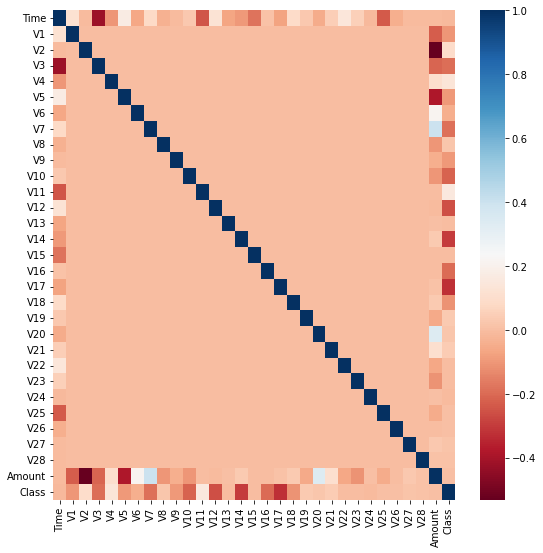

In [35]:
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [36]:
import numpy as np

In [37]:

# 이상치를 탐색하고 삭제한 데이터를 반환하는 함수
def get_outlier(df=None,columns=None,weight=1.5):
    fraud = df[df['Class']==1][columns]
    q25 = np.percentile(fraud.values, 25)
    q75 = np.percentile(fraud.values, 75)
    iqr = q75 - q25
    iqr_weight = iqr*weight
    lowest_val = q25 - iqr_weight
    highest_val = q75 + iqr_weight
    
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

In [38]:
get_outlier(card_df,'V14')

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [39]:
get_outlier(card_df,'V17')

Int64Index([], dtype='int64')

In [40]:
outlier_index = get_outlier(df=card_df, columns='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [41]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, columns='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, X_train, X_test,y_train, y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train,y_test)


### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율:0.6712, f1-스코어:0.7597, auc스코어:0.9743
### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율:0.8288, f1-스코어:0.8897, auc스코어:0.9780


## OverSampling 해보자
부족한 사기사례 데이터를 증강을 통해서 데이터 수를 확보하고 학습을 해보자

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
smote = SMOTE(random_state=0)

X_train_over, y_train_over  = smote.fit_sample(X_train,y_train)

In [44]:
X_train_over.shape

(398040, 29)

In [45]:
y_train_over.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

In [46]:
lr_clf = LogisticRegression()
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, X_train_over, X_test,y_train_over, y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train,y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율:0.9247, f1-스코어:0.1023, auc스코어:0.9737
### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율:0.8288, f1-스코어:0.8897, auc스코어:0.9780


In [47]:
from sklearn.metrics import precision_recall_curve

In [48]:
def precision_recall_curve_plot(y_test,pred_proba):
    precisions,recalls,thresholds = precision_recall_curve(y_test,pred_proba)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.legend()
    plt.grid()    
    plt.show()


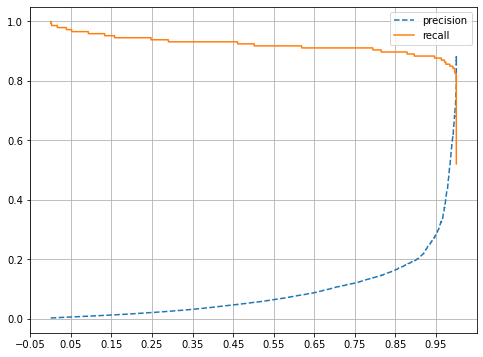

In [49]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])